In [ ]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

num_workers = 0
batch_size = 64

transform = transforms.ToTensor()
train_data = MNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, num_workers=num_workers, batch_size=batch_size)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


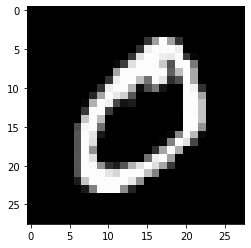

In [ ]:
data_iter = iter(train_loader)
images, labels = data_iter.next()
images = images.numpy()

img = np.squeeze(images[1])
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [ ]:
import torch.nn as nn
import torch.nn.functional as func

class Discriminator(nn.Module):
    def __init__(self, n_inputs, hidden_dim, n_outputs):
        super(Discriminator, self).__init__()
        
        # hidden layers
        self.fc1 = nn.Linear(n_inputs, hidden_dim*4)  # 784
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*3) 
        
        # final layer
        self.fc3 = nn.Linear(hidden_dim*3, n_outputs)
        
        # dropout
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = x.view(-1, 784)
        
        # hidden layers
        x = self.fc1(x)
        x = func.leaky_relu(x, 0.2)
        x = self.dropout(x)
        x = self.fc2(x)
        x = func.leaky_relu(x, 0.2)
        x = self.dropout(x)

        # final layer
        out = self.fc3(x)
        
        return out

In [ ]:
class Generator(nn.Module):
    def __init__(self, n_inputs, hidden_dim, n_outputs):
        super(Generator, self).__init__()
        
        # hidden layers
        self.fc1 = nn.Linear(n_inputs, hidden_dim*3)  # z_size
        self.fc2 = nn.Linear(hidden_dim*3, hidden_dim*4) 
        
        # final layer
        self.fc3 = nn.Linear(hidden_dim*4, n_outputs)
        
        # dropout
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        
        # hidden layers
        x = self.fc1(x)
        x = func.leaky_relu(x, 0.2)
        x = self.dropout(x)
        x = self.fc2(x)
        x = func.leaky_relu(x, 0.2)
        x = self.dropout(x)
     
        # final layer
        out = func.tanh(self.fc3(x))
        
        return out

In [ ]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 64
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

In [ ]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=96, bias=True)
  (fc3): Linear(in_features=96, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=64, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [ ]:
# Calculate losses
def real_loss(D_out):
    batch_size = D_out.size(0)
    # label smoothing

    labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [ ]:
import torch.optim as optim

# Optimizers
lr = 0.0003

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [ ]:
import pickle as pkl

# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=32
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)
        
        # 2. Train with fake images
        
        # Generate fake images
        # gradients don't have to flow during this step
        with torch.no_grad():
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.3908 | g_loss: 0.6749
Epoch [    1/  100] | d_loss: 0.1677 | g_loss: 3.6693
Epoch [    1/  100] | d_loss: 0.5315 | g_loss: 2.4306
Epoch [    2/  100] | d_loss: 0.4952 | g_loss: 3.2069
Epoch [    2/  100] | d_loss: 0.7280 | g_loss: 1.8827
Epoch [    2/  100] | d_loss: 0.4884 | g_loss: 2.4643
Epoch [    3/  100] | d_loss: 0.4908 | g_loss: 2.4051
Epoch [    3/  100] | d_loss: 0.4916 | g_loss: 2.2732
Epoch [    3/  100] | d_loss: 0.3412 | g_loss: 3.2986
Epoch [    4/  100] | d_loss: 0.4960 | g_loss: 3.0871
Epoch [    4/  100] | d_loss: 0.6072 | g_loss: 2.0667
Epoch [    4/  100] | d_loss: 0.7425 | g_loss: 1.8626
Epoch [    5/  100] | d_loss: 0.9615 | g_loss: 2.3981
Epoch [    5/  100] | d_loss: 0.8147 | g_loss: 1.7061
Epoch [    5/  100] | d_loss: 0.6063 | g_loss: 1.8612
Epoch [    6/  100] | d_loss: 0.7035 | g_loss: 2.3190
Epoch [    6/  100] | d_loss: 0.6826 | g_loss: 2.0063
Epoch [    6/  100] | d_loss: 0.6095 | g_loss: 1.7731
Epoch [    7/  100] | d_loss

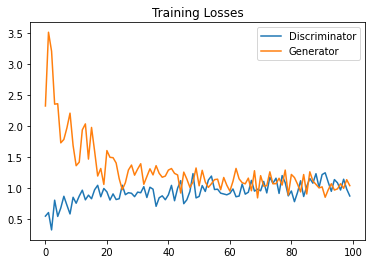

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [ ]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

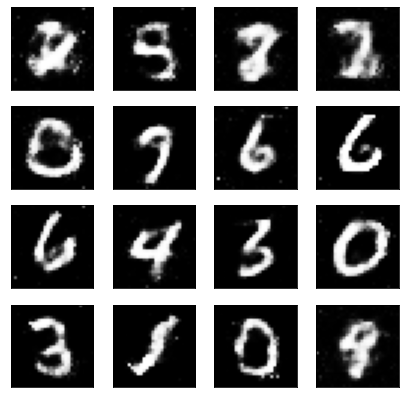

In [ ]:
view_samples(-1, samples)

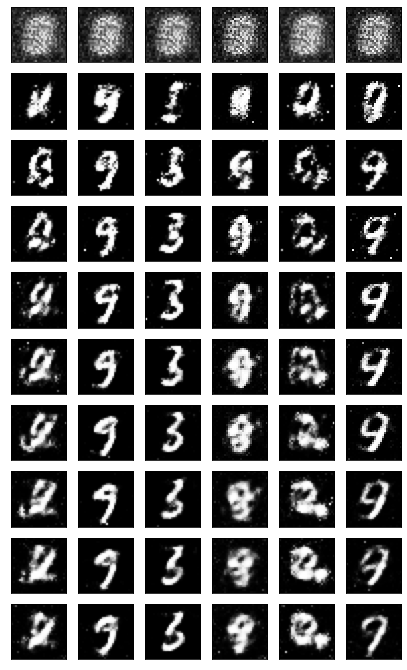

In [ ]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


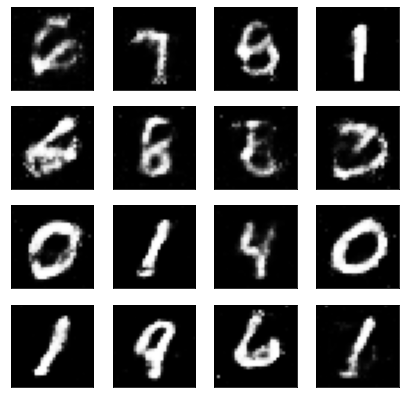

In [ ]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])